In [28]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datasource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'



0.4.1


float32 (256, 256) float32 (256, 256)


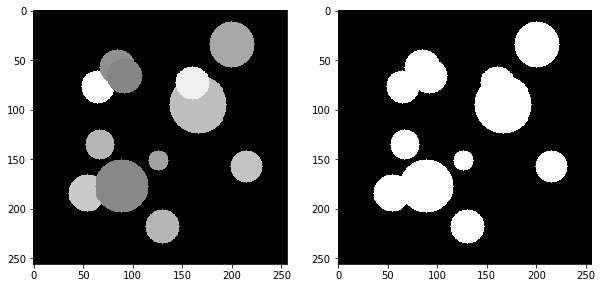

In [10]:
imwidth = 256
imheight = 256
numimgs = 500

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height),np.float32)
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=0#np.random.uniform(0,1.0,size=image.shape)
    
    return np.maximum(image,norm).astype(np.float32),(image>0).astype(np.float32)

def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
im,mask=createTestImage(imwidth,imheight)
print(im.dtype,im.shape,mask.dtype,mask.shape)
plotPair(im,mask)

float32 (500, 256, 256, 1) float32 (500, 256, 256)
float32 (1, 1, 256, 256) float32 (1, 1, 256, 256)


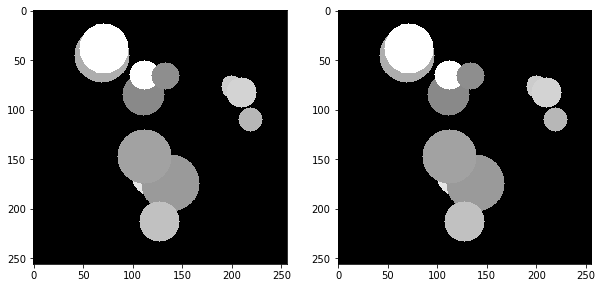

In [11]:
dataset=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]

print(imgin.dtype,imgin.shape,maskin.dtype,maskin.shape)
src=datasource.DataSource(imgin,imgin,augments=[pytorchutils.convertBoth])

with src.threadBatchGen(1) as gen:
    im,im1=gen()
    print(im.dtype,im.shape,im1.dtype,im1.shape)
    plotPair(im[0,0],im1[0,0])

In [39]:
class AEMgrNB(pytorchutils.AutoEncoderMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.AutoEncoderMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        with self.src.threadBatchGen(self.batchSize) as gen:
            self.train(gen,self.trainSteps,1,10)
        
    def updateStep(self,step,steploss):
        self.updateGraphVals({'loss':steploss},('loss',))
        
        if step<10 or step%5==0:
            images,_=self.traininputs
            recons=self.netoutputs[0]

            image=self.toNumpy(images[0,0])
            recon=self.toNumpy(recons[0,0].sigmoid())
            
            imgmap=OrderedDict([
                ('Image',image),
                ('Recon',recon),
                ('Diff',np.abs(image-recon)),
            ])
            
            self.updateImageVals(imgmap)
        

learningRate=1e-4
trainSteps=5000
batchSize=20
filters=(8, 16, 32)
strides=(1,  2,  2)
resunits=2
interunits=2
kernelsize=5

net=pytorchnet.AutoEncoder(1,1,filters,strides,kernelsize,numResUnits=resunits,numInterUnits=interunits)
    
mgr=AEMgrNB(net,src,batchSize,trainSteps)
mgr.start()

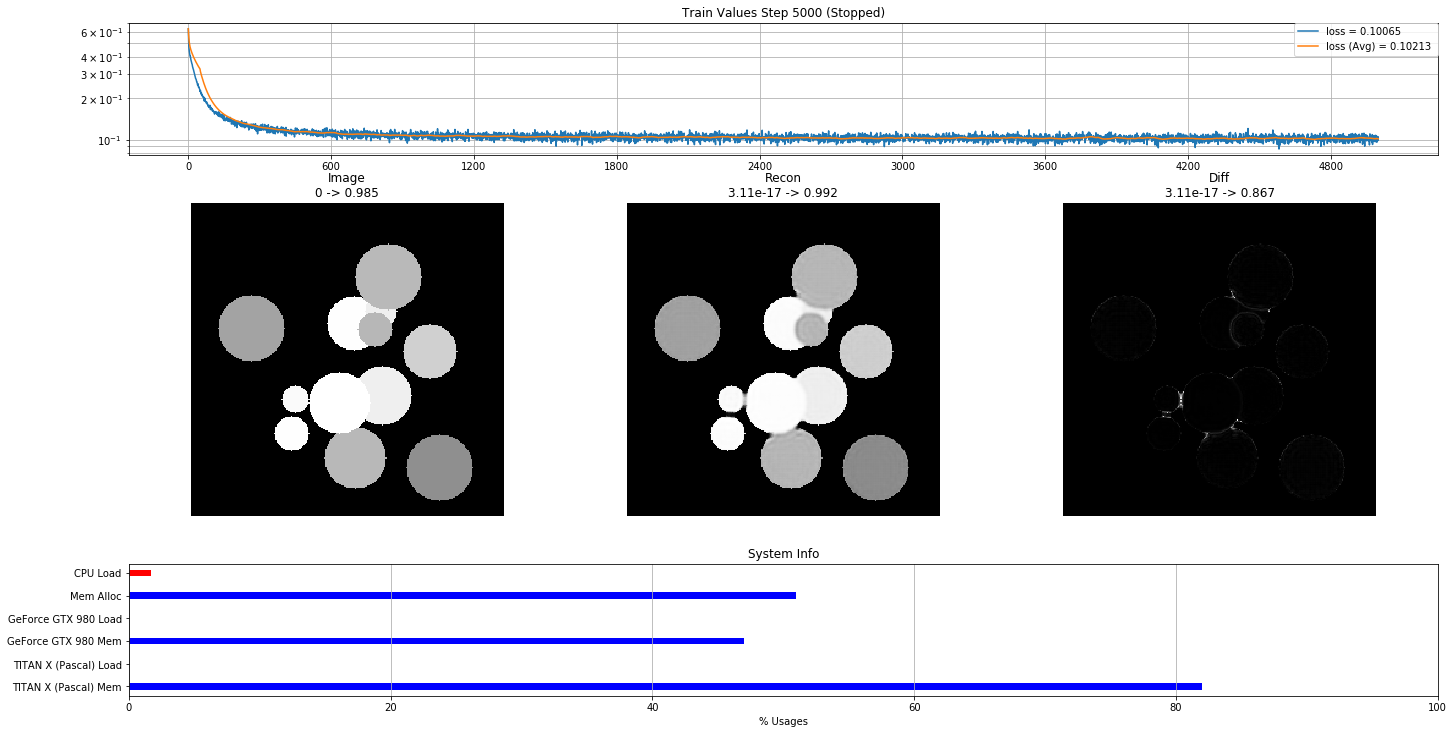

In [40]:
mgr.displayMonitor()

In [41]:
learningRate=1e-4
trainSteps=5000
batchSize=20
filters=(8, 16, 32, 64, 128)
strides=(1,  2,  2,  2,   2)
resunits=1
interunits=1
kernelsize=5

net=pytorchnet.AutoEncoder(1,1,filters,strides,kernelsize,numResUnits=resunits,numInterUnits=interunits)
    
mgr=AEMgrNB(net,src,batchSize,trainSteps)
mgr.start()

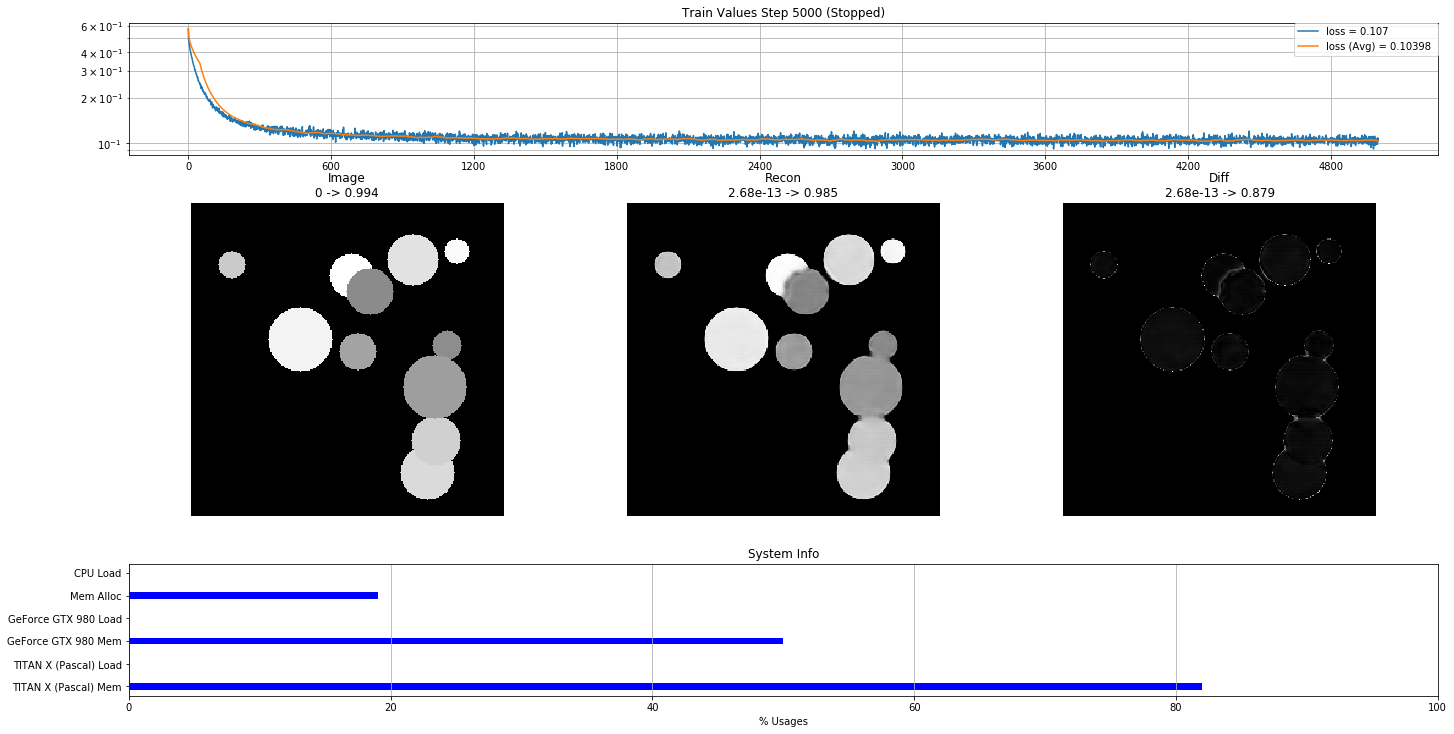

In [42]:
mgr.displayMonitor()